In [25]:
import Pkg

# List of external packages to install
# Note: LinearAlgebra and SparseArrays are standard libraries included 
# with Julia, so they do not need to be installed separately.
packages = [
    "BoundaryValueDiffEq",
    "ModelingToolkit",
    "MethodOfLines",
    "DifferentialEquations",
    "NonlinearSolve",
    "DomainSets",
    "FFTW",
    "Plots",
    "BifurcationKit",
    "LinearAlgebra",
    "SparseArrays",
    "Setfield",
    "Accessors",
]

# Add the packages
Pkg.add(packages)

   Resolving package versions...
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Manifest.toml`


In [26]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
using FFTW
using Plots
using BifurcationKit
using Setfield 
using Accessors

In [27]:
# 1. Physics: 2-DOF Oscillator
# u[1]=x1, u[2]=v1, u[3]=x2, u[4]=v2
function two_mass_ode!(du, u, p, t)
    # Unpack state for clarity
    x1, v1, x2, v2 = u[1], u[2], u[3], u[4]
    
    # Forces
    # Spring/Damper 1 (Wall to m1)
    F_spring1 = -p.k1 * x1
    F_damp1   = -p.c1 * v1
    
    # Spring/Damper 2 (m1 to m2)
    F_spring2 = p.k2 * (x2 - x1)
    F_damp2   = p.c2 * (v2 - v1)
    
    # Driving Force (applied to m2)
    F_drive   = p.F * cos(p.omega * t)

    # Equations of Motion
    du[1] = v1
    du[2] = (F_spring1 + F_spring2 + F_damp1 + F_damp2) / p.m1
    
    du[3] = v2
    du[4] = (-F_spring2 - F_damp2 + F_drive) / p.m2
end

# 2. Parameters
par_2dof = (
    m1 = 1.0, m2 = 1.0, 
    k1 = 1.0, k2 = 1.0, 
    c1 = 0.05, c2 = 0.01, 
    F = 0.5, omega = 0.5
)

(m1 = 1.0, m2 = 1.0, k1 = 1.0, k2 = 1.0, c1 = 0.05, c2 = 0.01, F = 0.5, omega = 0.5)

In [28]:
# 3. Poincare Map (4-Dimensional)
function poincare_map_2dof(u, p)
    omega = (p isa Real) ? p : p.omega
    T = 2π / omega
    
    # Integrate the 4D system
    prob = ODEProblem(two_mass_ode!, u, (0.0, T), p)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, save_everystep=false)
    
    return sol[end] - u
end

poincare_map_2dof (generic function with 1 method)

In [29]:
# 4. Problem Definition
u0 = [0.0, 0.0, 0.0, 0.0]

prob = BifurcationProblem(poincare_map_2dof, u0, par_2dof, (@optic _.omega);
    record_from_solution = (x, p; k...) -> begin
        # Robust parameter reconstruction
        current_omega = (p isa Real) ? p : p.omega
        # Reconstruct full parameter tuple
        p_full = (m1=par_2dof.m1, m2=par_2dof.m2, k1=par_2dof.k1, k2=par_2dof.k2, 
                  c1=par_2dof.c1, c2=par_2dof.c2, F=par_2dof.F, omega=Float64(current_omega))
        
        T = 2π / p_full.omega
        prob_rec = ODEProblem(two_mass_ode!, x, (0.0, T), p_full)
        sol_rec = solve(prob_rec, Tsit5(), reltol=1e-8, abstol=1e-8)
        
        # We plot the amplitude of Mass 2 
        return maximum(abs.(sol_rec[3, :]))
    end
)

┌─ Bifurcation Problem with uType Vector{Float64}
├─ Inplace: false
├─ Dimension: 4
├─ Symmetric: false
└─ Parameter: omega

In [30]:
# 5. Continuation Options
opts = ContinuationPar(
    p_min = 0.01, 
    p_max = 2.5,     
    ds = 0.01,       # Step size
    max_steps = 2000, 
    detect_bifurcation = 0
)

ContinuationPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  dsmin: Float64 0.0001
  dsmax: Float64 0.1
  ds: Float64 0.01
  a: Float64 0.5
  p_min: Float64 0.01
  p_max: Float64 2.5
  max_steps: Int64 2000
  newton_options: NewtonPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  η: Float64 150.0
  save_to_file: Bool false
  save_sol_every_step: Int64 1
  nev: Int64 3
  save_eig_every_step: Int64 1
  save_eigenvectors: Bool true
  plot_every_step: Int64 10
  tol_stability: Float64 1.0e-10
  detect_fold: Bool true
  detect_bifurcation: Int64 0
  dsmin_bisection: Float64 1.0e-16
  n_inversion: Int64 2
  max_bisection_steps: Int64 25
  tol_bisection_eigenvalue: Float64 1.0e-16
  detect_event: Int64 0
  tol_param_bisection_event: Float64 1.0e-16
  detect_loop: Bool false


In [31]:
# 6. Run Continuation
branch = continuation(prob, PALC(), opts)

 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 463
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter omega starts at 0.5, ends at 2.5
 ├─ Algo: PALC [Secant]
 └─ Special points:

- #  1, endpoint at omega ≈ +2.50000000,                                                                     step = 462


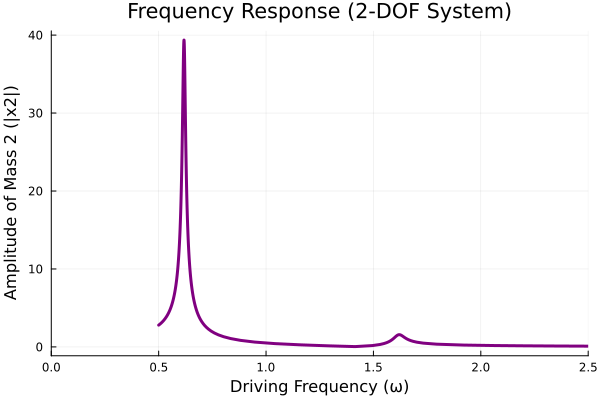

In [32]:
# 7. Plotting
plot(branch, 
    title = "Frequency Response (2-DOF System)",
    xlabel = "Driving Frequency (ω)",
    ylabel = "Amplitude of Mass 2 (|x2|)",
    lw = 3, color = :purple, legend = false,
    xlims = (0, 2.5)
)